<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bert Sentiment Analysis

* Aguirregaray, Mauro

[Ejemplo similar en Pytorch](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=m_mRflxPl32F)

## Objetivo para este desafío

* Cambiar max_length respecto a lo visto en clase
* Agregar una capa densa para el fine tunning
* Modificar el learning rate del optimizador
* Se aumenta la cantidad de épocas

En un principio este desafío contemplaba hacer una comparación para diferentes max_length y diferentes modelos. Sin embargo, me encontré con el siguiente problema:

**No logré reinstanciar el modelo de Bert con los parámetros iniciales**, es decir, cuando re-entrenaba el modelo con otros parámetros Bert no volvía al estado inicial sino que guarda parte del entrenamiento anterior, y de esta manera carece de sentido la comparación.

Dado este inconveniente simplemente se va a hacer un solo entrenamiento planteando las modificaciones iniciales y se va a comparar con el que se vió en clase.

In [1]:
!pip install transformers --quiet

In [2]:
import tensorflow
from transformers import TFBertModel

### Definiendo modelo

In [3]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Se modifica el max length de estudio de palabras en cada review, pero mantengo el output de 3 valoraciones para poder comparar con lo visto en clase.

In [4]:
max_length = 200
output_shape = 3

Se agrega una capa densa de 256 nodos para incorporara más parámetros entrenables, así como que se disminuye el learning rate por defecto (0.001).

In [5]:
bert_model.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)

# Se incluye capa densa previa al output
x = tensorflow.keras.layers.Dense(256, activation='relu')(x)

output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

model = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Definir el optimizador con un learning rate menor
optimizer = tensorflow.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 200)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 200, 7                                       

In [7]:
#Función para graficar resultados
def plot_train_metrics(history):
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')
    plt.show()

### Datos

No modificamos nada de lo visto en clase.
Utilizaremos como dataset críticas de Google Apps en formato csv.

In [8]:
# Descargar la carpeta de dataset
!curl -L -o 'apps.csv' 'https://drive.google.com/u/0/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV&export=download&confirm=t'
!curl -L -o 'reviews.csv' 'https://drive.google.com/u/0/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  131k  100  131k    0     0  52280      0  0:00:02  0:00:02 --:--:--  110k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 7002k  100 7002k    0     0   639k      0  0:00:10  0:00:10 --:--:-- 1958k


In [9]:
import pandas as pd
import seaborn as sns
# Armar el dataset
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


## Limpieza de datos

Balanceamos los datos para mantener solo 3 clases target.

In [12]:
# Balancear los datos
df['sentiment'] = df.score.apply(lambda x: 0 if x <=2 else 1 if x == 3 else 2)
class_names = ['negative', 'neutral', 'positive']

In [13]:
sentences = df['content'].values
print("sentences shape:", sentences.shape)
sentences[:3]

sentences shape: (15746,)


array(["Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.",
       'Used it for a fair amount of time without any problems. Suddenly then asked me to create an account or log using Google or FB. I used my Google one only to discover everything was gone!',
       "Your app sucks now!!!!! Used to be good but now doesn't update until I physically open it up and then close it then scroll and then it finally shows what I want to put on the list!!!!!! And I FRIGGEN paid for this garbage!!!!!!!"],
      dtype=object)

Median: 139.0


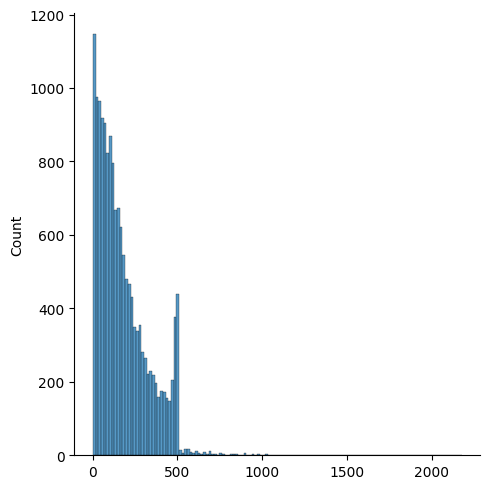

In [14]:
import numpy as np

sentence_lens = []

for sentence in sentences:
  sentence_lens.append(len(sentence))

print("Median:", np.median(sentence_lens))
sns.displot(sentence_lens)

In [15]:
from tensorflow.keras.utils import to_categorical

In [16]:
y = df['sentiment'].values
print("y shape:", y.shape)
y = to_categorical(y)
print(y[:3])
output_shape = y.shape[1]
print("output shape:", output_shape)

y shape: (15746,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
output shape: 3


## 1 - Data generator


Mantenemos el mismo procedimiento visto en clase.

In [17]:
from transformers import InputExample, InputFeatures  # Métodos para transformar el dataset
from transformers import BertTokenizer
import numpy as np

In [18]:
# Muy importante que para tensorflow los modelos Bert deben empezar con "TF"
# de lo contrario estaremos utilizando un modelo para pytorch

# Descargamos el modelo base de BERT más liviano y su correspondiente tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
# Del dataset original accederemos a los datos por índices (idx)
# mezclados aleatoriamente
from sklearn.model_selection import train_test_split
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [21]:
def convert_data_to_examples(text, labels, idx_train, idx_val):
    # Armamos un "InputExample" para los datos de entrenamiento y validación
    train_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_train]

    validation_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_val]

    return train_InputExamples, validation_InputExamples


def convert_examples_to_tf_dataset(examples, bert_tokenizer, max_length=512):
    # Transformamos los datos de entrada en tensorres de:
    # input_ids --> token id
    # attention_mask
    # token type
    features = []

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, attention_mask = (input_dict["input_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, label=e.label
            )
        )

    def gen():
    # Función generadora para no levantar todos los datos en un instante
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                },
                f.label,
            )

    return tensorflow.data.Dataset.from_generator(
        # Tensorflow dataset generator (basado en el generador y en el esquema de datos definido)
        gen,
        ({"input_ids": tensorflow.int32, "attention_mask": tensorflow.int32}, tensorflow.float32),
        (
            {
                "input_ids": tensorflow.TensorShape([None]),
                "attention_mask": tensorflow.TensorShape([None]),
            },
            tensorflow.TensorShape([output_shape]),
        ),
    )

In [22]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length)
# shuffle 100 --> mezcla los datos y los lee a de 100 unidades
# batch 32 --> ejecuta una epoca de entrenamiento de a 32 unidades
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length)
validation_data = validation_data.batch(32)

In [23]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [24]:
X_test = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [25]:
y_test = y[idx_test]
y_test

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

## 2 - BERT multiclass classification

In [26]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length)
# shuffle 100 --> mezcla los datos y los lee a de 100 unidades
# batch 32 --> ejecuta una epoca de entrenamiento de a 32 unidades
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length)
validation_data = validation_data.batch(32)
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')
X_test = [tf_batch['input_ids'],
          tf_batch['attention_mask']]
y_test = y[idx_test]


history = model.fit(train_data, epochs=10, validation_data=validation_data)


Epoch 1/10
315/315 [==============================] - 207s 595ms/step - loss: 1.0688 - accuracy: 0.4425 - f1_score: 0.4347 - val_loss: 0.9702 - val_accuracy: 0.5210 - val_f1_score: 0.4981
Epoch 2/10
315/315 [==============================] - 189s 600ms/step - loss: 0.9813 - accuracy: 0.5104 - f1_score: 0.4943 - val_loss: 0.9013 - val_accuracy: 0.5591 - val_f1_score: 0.4892
Epoch 3/10
315/315 [==============================] - 189s 600ms/step - loss: 0.9702 - accuracy: 0.5137 - f1_score: 0.4966 - val_loss: 0.8938 - val_accuracy: 0.5595 - val_f1_score: 0.4818
Epoch 4/10
315/315 [==============================] - 189s 600ms/step - loss: 0.9524 - accuracy: 0.5320 - f1_score: 0.5149 - val_loss: 0.9219 - val_accuracy: 0.5409 - val_f1_score: 0.4733
Epoch 5/10
315/315 [==============================] - 189s 600ms/step - loss: 0.9515 - accuracy: 0.5283 - f1_score: 0.5124 - val_loss: 0.8871 - val_accuracy: 0.5575 - val_f1_score: 0.4864
Epoch 6/10
315/315 [==============================] - 194s 6

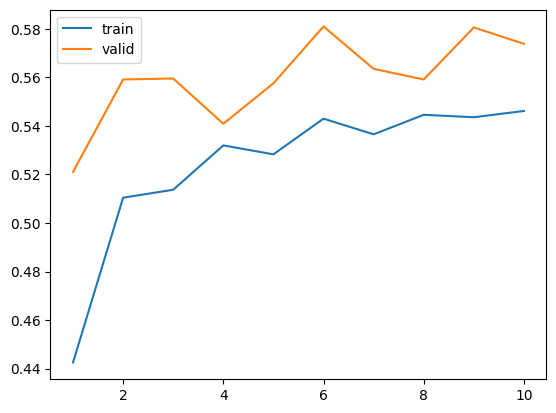

In [27]:
import matplotlib.pyplot as plt
plot_train_metrics(history)

Los resultados no mejoran significativamente a lo visto en clase aún cambiando los hiperparámetros iniciales.

Viendo los resultados podría ser interesante aumentar aún más la cantidad de epochs.

In [28]:
y_hat_prob = model.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 48s 454ms/step


array([[0.59326446, 0.2930931 , 0.11364245],
       [0.40343624, 0.2500104 , 0.34655342],
       [0.2364085 , 0.31508473, 0.44850677]], dtype=float32)

In [29]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [30]:
# Calcular la exactitud (accuracy)
scores = model.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 47s 450ms/step - loss: 0.8764 - accuracy: 0.5873 - f1_score: 0.5190


0.5873016119003296

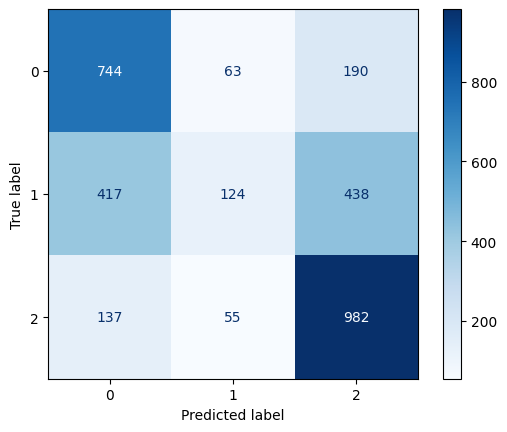

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(range(3)))
cmd.plot(cmap=plt.cm.Blues)
plt.show()

En la matriz de confusión se observa claramente el modelo es muy bueno determinando reviews buenas o malas, pero tiene muchas dificultades para identificar las neutras.

Esto es entendible pues una review termina siendo algo muy subjetivo y una persona puede no ser coherente entre lo que comenta y lo que puntúa, sobre todo en términos neutros.

## Salvar el modelo

In [32]:
model.save_weights('bert_weights.h5')

## Ensayo

In [33]:
################
### Positiva ###
################
text = "I love this app!"

#tf_batch = bert_tokenizer(text, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

X_ensayo = [tf_batch['input_ids'],
          tf_batch['attention_mask']]
y_prob_ensayo = model.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob)])

Inputs ids: tf.Tensor(
[[  101  1045  2293  2023 10439   999   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0  

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Clasificación: positive


<ipython-input-33-ec64a64a7600>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Clasificación:", class_names[int(y_prob)])


In [34]:
################
### Negativa ###
################
text = "I hate this app!"

#tf_batch = bert_tokenizer(text, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

X_ensayo = [tf_batch['input_ids'],
          tf_batch['attention_mask']]
y_prob_ensayo = model.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob)])

Inputs ids: tf.Tensor(
[[  101  1045  5223  2023 10439   999   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0  

<ipython-input-34-6fa3ba22d098>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Clasificación:", class_names[int(y_prob)])


In [41]:
###############
### Neutral ###
###############
text = "The app is mid"

#tf_batch = bert_tokenizer(text, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

X_ensayo = [tf_batch['input_ids'],
          tf_batch['attention_mask']]
y_prob_ensayo = model.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob)])

Inputs ids: tf.Tensor(
[[  101  1996 10439  2003  3054   102     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0  

<ipython-input-41-5d6f13f446e9>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Clasificación:", class_names[int(y_prob)])


In [35]:
###############
### Neutral ###
###############
text = ("The app is generally easy to use with a clean and intuitive interface. Navigation is straightforward, "
        "and it offers the basic features you'd expect. However, it can be slow at times, and there are occasional bugs that affect performance. "
        "The ads are a bit intrusive, which can disrupt the user experience. Customer support is responsive but not always able to resolve issues quickly. "
        "Overall, it’s a decent app for casual use, but there’s definitely room for improvement in terms of speed and stability.")

#tf_batch = bert_tokenizer(text, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

X_ensayo = [tf_batch['input_ids'],
          tf_batch['attention_mask']]
y_prob_ensayo = model.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob)])

Inputs ids: tf.Tensor(
[[  101  1996 10439  2003  3227  3733  2000  2224  2007  1037  4550  1998
  29202  8278  1012  9163  2003 19647  1010  1998  2009  4107  1996  3937
   2838  2017  1005  1040  5987  1012  2174  1010  2009  2064  2022  4030
   2012  2335  1010  1998  2045  2024  8138 12883  2008  7461  2836  1012
   1996 14997  2024  1037  2978 20014  7946  3512  1010  2029  2064 23217
   1996  5310  3325  1012  8013  2490  2003 26651  2021  2025  2467  2583
   2000 10663  3314  2855  1012  3452  1010  2009  1521  1055  1037 11519
  10439  2005 10017  2224  1010  2021  2045  1521  1055  5791  2282  2005
   7620  1999  3408  1997  3177  1998  9211  1012   102     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0  

<ipython-input-35-e8984014849c>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Clasificación:", class_names[int(y_prob)])


In [42]:
################
### Negative ###
################
text = ("This app is extremely disappointing. The interface is cluttered and hard to navigate, making it frustrating to use. "
        "It crashes frequently, and the performance is unbearably slow. Ads pop up constantly, interrupting any attempt to use the app smoothly. "
        "The features are outdated, and some don’t even work as intended. Customer support is unhelpful and slow to respond, offering no real solutions. "
        "There’s a severe lack of updates or improvements, leaving the app feeling neglected. Overall, it's one of the worst apps I’ve used, "
        "and I wouldn’t recommend it to anyone.")


#tf_batch = bert_tokenizer(text, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

X_ensayo = [tf_batch['input_ids'],
          tf_batch['attention_mask']]
y_prob_ensayo = model.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob)])

Inputs ids: tf.Tensor(
[[  101  2023 10439  2003  5186 15640  1012  1996  8278  2003 18856 23128
   1998  2524  2000 22149  1010  2437  2009 25198  2000  2224  1012  2009
  19119  4703  1010  1998  1996  2836  2003  4895  4783  5400  6321  4030
   1012 14997  3769  2039  7887  1010 22602  2151  3535  2000  2224  1996
  10439 15299  1012  1996  2838  2024 25963  1010  1998  2070  2123  1521
   1056  2130  2147  2004  3832  1012  8013  2490  2003  4895 16001 14376
   5313  1998  4030  2000  6869  1010  5378  2053  2613  7300  1012  2045
   1521  1055  1037  5729  3768  1997 14409  2030  8377  1010  2975  1996
  10439  3110 15486  1012  3452  1010  2009  1005  1055  2028  1997  1996
   5409 18726  1045  1521  2310  2109  1010  1998  1045  2876  1521  1056
  16755  2009  2000  3087  1012   102     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0  

<ipython-input-42-9f41ed509409>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Clasificación:", class_names[int(y_prob)])


## Conclusiones

Luego de las dificultades encontradas con el funcionamiento del modelo de Bert, se logró desarollar correctamente el desafío.

No se llegó a resultados significativamente mejores que lo visto en clase a nivel de métricas aún cambiando el máximo de palabras y la arquitectura del modelo a entrenar.

Sin embargo, resulta interesante como en la inferencia se observa lo mismo que mostraba la matriz de confusión. El modelo logra sin problemas identificar reviews buenas o malas, ya sean complejas o no, pero cuando hay una reseña neutra y compleja la predice como positiva.

En conclusión creo que está muy bueno utilizar BERT y es sorprendente lo bien que funciona entrenando muy pocos hiperparámetros. Sin embargo, la implementación en tensorflow o al menos la vista en clase considero que no es muy conveniente para poder utilizar en un entorno productivo por los problemas de dependencias encontrados.